# Training a better model

In [2]:
from theano.sandbox import cuda

In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = "data/redux/sample/"
#path = "data/redux/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

#batch_size=64
batch_size=4

## Are we underfitting?

So far, our validation accuracy > training accuracy. That leads to two obvious questions:

1. How is this possible?
2. Is this desirable?

Answer(1): it happens because of *dropout*. 
- Dropout = a layer that randomly deletes (i.e. sets to zero) each activation in the previous layer with probability *p* (generally 0.5). 
- This only happens during training, not when calculating the accuracy on the validation set. That's why validation accuracy > training accuracy.

The purpose of dropout is to avoid overfitting.
- Doing Dropout during training ensures that no one part of the neural network can overfit to one part of the training set. 
- Dropout allows us to create rich models without overfitting. 
- If overused, it can result in underfitting. --> Be careful with our model.

Answer(2): this is probably not desirable. 
- validation accuracy is higher than training accuracy = a strong sign of underfitting.
- If this happens, it's likely that we can get better validation set results with less (or no) dropout. 

Let's try removing dropout entirely, and see what happens!
(The VGG model has Dropout because the VGG authors found it necessary for the imagenet competition. But it may not be necessary for dogs v cats,.)

## Removing Dropout

High-level approach:
- Start with our fine-tuned cats vs dogs model (with dropout).
- Remove dropout from the dense layers.
- Fine-tune all the dense layers.

Steps:
1. Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)
2. Split the model between the convolutional (*conv*) layers and the dense layers
3. Pre-calculate the output of the conv layers (*OCVL*) (to avoid re-calculating them on every epoch)
4. Create a new model with just the dense layers, and dropout p set to zero
5. Train this new model using *OCVL* as training data.

### (1) Load finetuned VGG model with binary dependent
Start with a working model. Load VGG 16 model and change it to predict our binary dependent (dogs v cats):

In [19]:
model = vgg_ft(2)

Load our fine-tuned weights:

In [20]:
model.load_weights(model_path+'finetune3.h5')

### (2) Split the model between the convolutional (*conv*) layers and the dense layers

It is best for us to pre-calculate the input to the fully connected layers, i.e. the Flatten() layer.

#### (2.1) Find the index of the last conv layer

In [21]:
layers = model.layers

In [22]:
last_conv_idx = [index for index,layer in enumerate(layers)
                    if type(layer) is Convolution2D][-1]

In [23]:
last_conv_idx

30

In [24]:
layers[last_conv_idx]

#### (2.2) Create a new model that contains just the layers up to and including this layer

In [25]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - aka. fully connected (FC) layers
fc_layers = layers[last_conv_idx+1:]

### (3) Pre-calculate the output of the model with only the conv layers: conv_model
Use the same approach to creating features as we used when we created the linear model from the imagenet predictions in the last lesson - it's only the model that has changed.
- There's a small number of "recipes" that can get us a long way!

In [15]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [18]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [19]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [21]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [22]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [23]:
trn_features.shape

(16, 512, 14, 14)

### (4) Create a new model with just the dense layers, and dropout p set to zero
For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG16, so that we can copy the pre-trained weights over from that model.
- Set the dropout layer's p values to zero, so as to remove dropout.

In [26]:
# Half the weights because we'll remove dropout.
def proc_wgts(layer):
    return [o/2 for o in layer.get_weights()]

In [27]:
# A finely tuned model needs to be updated very slowly.
opt = RMSprop(lr=0.00001, rho=0.7)

In [28]:
# Copy the weights from the pre-trained model.
def get_fc_model():
    #based on: vgg16.py :: create, FCBlock
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])
    
    for l1,l2 in zip(model.layers, fc_layers):
        l1.set_weights(proc_wgts(l2))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
fc_model = get_fc_model()

### (5) Train this model using the output of conv layers as training data.
Fit the model:

In [29]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8,
            batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 16 samples, validate on 8 samples
Epoch 1/8
16/16 [==============================] - 9s - loss: 2.0489e-07 - acc: 1.0000 - val_loss: 1.2018e-05 - val_acc: 1.0000
Epoch 2/8
16/16 [==============================] - 9s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.2018e-05 - val_acc: 1.0000
Epoch 3/8
16/16 [==============================] - 9s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.2018e-05 - val_acc: 1.0000

In [30]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [31]:
fc_model.load_weights(model_path+'no_dropout.h5')

# Reducing overfitting

Now the model is overfitting. We can take a number of steps to reduce this.

## Approaches to reducing overfitting

To reduce overfitting, we should try other techniques first
- Do dropout (or other regularization approaches) only when necessary.
- Because regularlization biases our model towards simplicity. 

**The order that we recommend using for reducing overfitting**:

1. Add more data
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization
5. Reduce architecture complexity.

Step (1) isn't relevant because assume that you've already collected as much data as you can. 

Step (2): data augmentation = create additional synthetic data, by modifying input data reasonably.

- For images, involve one or more of: flip, rotate, zoom, crop, pan, minor color changes.

Which types of augmentation are appropriate depends on your data. 

- For regular images, for instance, you'll want to use horizontal flipping, but not vertical flipping.
- (since an upside down car is much less common than a car the right way up).

** Recommend: always using data augmentation **

- unless you have so much data that your model will never see the same input twice.

## About data augmentation

In Keras, data augmentation is automated (convenient). 
- Define what types and maximum amounts of augmentation you want. 
- Keras ensures that every item of every batch is randomly changed according to these settings. 

To define a generator that includes data augmentation:

In [5]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
        channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')
        #height_shift_range=0.1, width_zoom_range=0.2, shear_range=0.15, zoom_range=0.1,
        #channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

Let's take a look at how this generator changes a single image:
- the details of this code don't matter much, 
- but feel free to read the comments and keras docs to understand the details if you're interested.

In [7]:
# Create a batch of a single image
img = np.expand_dims(ndimage.imread('data/redux/test/unknown/7.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [8]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

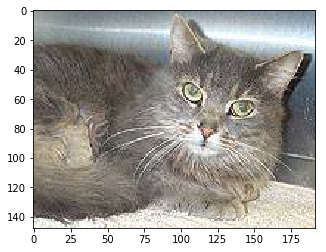

In [9]:
# The original image
plt.imshow(img[0])

As you can see below, data augmentation is an intuitive approach to generating richer input data. 

1. Use your intuition as a guide to appropriate data augmentation.
2. Test your intuition by checking the results of different augmentation approaches.

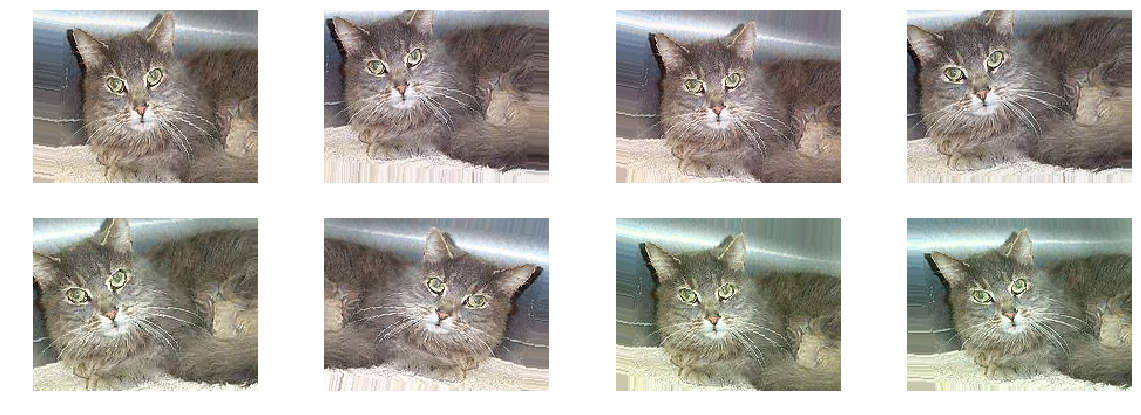

In [10]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [11]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

## Adding data augmentation

Steps:
- try adding a small amount of data augmentation, 
- see result if we reduce overfitting. 

Use the same method used to finetune the dense layers in lesson 2, except that we will use a generator with augmentation configured. 

Here's how we set up the generator, and create batches from it:

In [13]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                              height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [14]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


When using data augmentation, we can't pre-compute our convolutional layer features, 
- because every input image are randomly changed. 
- That is, in each epoch of training, the same image will undergo different data augmentation, so the results of the convolutional layers will be different.

Therefore, in order to allow data to flow through all the conv layers and our new dense layers, we ...

- (a) ensure that the conv layers are not trainable,
- (b) attach our fully connected model to the convolutional model

In [29]:
fc_model = get_fc_model()

In [30]:
# (a)
for layer in conv_model.layers: layer.trainable = False
# (b) It's easy to connect two models together!
conv_model.add(fc_model)

Now we can compile, train, and save our model.

Note: we use fit_generator() since we want to pull random images from the directories on every batch.

In [31]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8,
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                                            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
conv_model.save_weights(model_path + 'aug1.h5')

In [ ]:
conv_model.load_weights(model_path + 'aug1.h5')